# Tensorflow Data Pipeline

data input 방법
 * 학습데이터 전체 메모리에 로드
     * 데이터가 많을 경우 메모리 용량 한계
 * generator를 사용하여 batch 사이즈 만큼만 메모리에 로드
     * 학습 전 batch 사이즈 만큼 메모리에 로드 하기 위한 오버헤드 발생
 
tensorflow에서 data pipeline을 만들어 GPU가 학습하는동안 cpu thread가 generator를 prefetch하여 tensorflow 모델에 input 하는 과정을 학습

>참조: [Tensorflow Programmer's Guide Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)
 * generator: python generator를 구현하여 data read
 * tf record: image, annotation 파일을 이용하여 tf record 파일을 생성
 * string_input_producer: file name 큐 생성
 * tf.train.shuffle.batch: batch 큐 생성
 * tf.contrib.dataset: 복잡한 input pipeline을 단순화 하기 위한 API

 * package 설치
     * pip install matplotlib

## Generator

 iterator 를 생성해 주는 function. next()메소드를 이용해 데이터에 순차적으로 접근 가능한 object
 메모리를 효율적으로 사용하기 위해 사용
  * next() 메소드를 통해 차례로 값에 접근할 때마다 메모리에 적재하는 방식이다.

In [1]:
def generator(n):
    i = 0
    while i < n:
        yield i
        i += 1
        
iterator = generator(10)
print (iterator)
for x in range(5):
    print (next(iterator))

<generator object generator at 0x7f02aa157d58>
0
1
2
3
4


In [2]:
import tensorflow as tf
import os
import random
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

_NUM_SHARDS = 5
_DATA_DIR = "/root/data/mnist_png"

def get_filenames_and_classes(dataset_dir, train_val):
    mnist_root = os.path.join(dataset_dir, train_val)
    directories = []
    class_names = []
    print (mnist_root)
    print (os.listdir(mnist_root))
    for filename in os.listdir(mnist_root):
        path = os.path.join(mnist_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    print (directories)
    print (class_names)
    for directory in directories:
        for filename in os.listdir(directory):
            #print (filename)
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

training_filenames, training_class_names = get_filenames_and_classes(_DATA_DIR, "training")
validation_filenames, validation_class_names = get_filenames_and_classes(_DATA_DIR, "testing")
#print (validation_filenames)

/root/data/mnist_png/training
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']
['/root/data/mnist_png/training/5', '/root/data/mnist_png/training/1', '/root/data/mnist_png/training/4', '/root/data/mnist_png/training/7', '/root/data/mnist_png/training/0', '/root/data/mnist_png/training/3', '/root/data/mnist_png/training/9', '/root/data/mnist_png/training/2', '/root/data/mnist_png/training/8', '/root/data/mnist_png/training/6']
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']
/root/data/mnist_png/testing
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']
['/root/data/mnist_png/testing/5', '/root/data/mnist_png/testing/1', '/root/data/mnist_png/testing/4', '/root/data/mnist_png/testing/7', '/root/data/mnist_png/testing/0', '/root/data/mnist_png/testing/3', '/root/data/mnist_png/testing/9', '/root/data/mnist_png/testing/2', '/root/data/mnist_png/testing/8', '/root/data/mnist_png/testing/6']
['5', '1', '4', '7', '0', '3', '9', '2', '8', '6']


In [3]:
def generator(filenames, class_names, data_len, batch_size, epoch):
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))
    print (class_names)
    print (class_names_to_ids)
    
    for i in range(epoch):
        i = 0
        while i < data_len:

            if (i + batch_size) > data_len:
                batch_count = data_len - i
            else:
                batch_count = batch_size

            batch_data = np.zeros((batch_count, 28, 28))
            batch_label = np.zeros((batch_count, 1))

            for j in range(batch_count):
                filename = filenames[i+j]
                batch_data[j] = plt.imread(filename)
                #'/root/data/mnist_png/testing/6/4698.png' -> '/root/data/mnist_png/testing/6' -> '6'
                class_name = os.path.basename(os.path.dirname(filenames[i]))
                #string to int
                batch_label[j] = class_names_to_ids[class_name]

            yield batch_data, batch_label
            i = i + batch_size

data_len = len(validation_filenames)
batch_size = 14
epoch = 2
gen = generator(validation_filenames, validation_class_names, data_len, batch_size, epoch)

gen_count = np.ceil(data_len/batch_size)

for i in range(int(gen_count)*epoch):
    batch_data, batch_label = next(gen)
    #print (np.shape(batch_data), np.shape(batch_label))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'6': 6, '8': 8, '2': 2, '9': 9, '3': 3, '0': 0, '1': 1, '4': 4, '5': 5, '7': 7}


## tf record

 여러곳에 흩어져 있는 이미지와 annotation을 binary 파일로 저장. <br/>
 분산된 이미지 대신 통합된 binary 파일 read 
  * image와 label을 파일 하나로 저장 
  * hdd를 사용할 경우, disk 헤더 이동시간을 줄여 파일 읽기 시간을 최적화

In [4]:
#Helper class that provides TensorFlow image coding utilities.
class ImageReader(object):

    def __init__(self):
        # Initializes function that decodes 1 channel png data.
        self._decode_png_data = tf.placeholder(dtype=tf.string)
        self._decode_png = tf.image.decode_png(self._decode_png_data, channels=1)

    def read_image_dims(self, sess, image_data):
        image = self.decode_png(sess, image_data)
        return image.shape[0], image.shape[1]
    #decode string image data to int image data
    def decode_png(self, sess, image_data):
        image = sess.run(self._decode_png,
                         feed_dict={self._decode_png_data: image_data})
        return image

# make tensorflow record file name
def get_dataset_filename(dataset_dir, split_name, shard_id):
    output_filename = 'mnist_%s_%05d-of-%05d.tfrecord' % (
        split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

# Creates a TensorFlow Record Feature with value as a 64 bit integer.
def int64_feature(values):
    # if value is not tuple or list, make value to list
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

# Creates a TensorFlow Record Feature with value as a byte array
def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

#define tesnorflow record format
def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
    }))

#Converts the given filenames to a TFRecord dataset.
#
#      Args:
#        split_name: The name of the dataset, either 'train' or 'validation'.
#        filenames: A list of absolute paths to png or jpg images.
#        class_names_to_ids: A dictionary from class names (strings) to ids
#          (integers).
#        dataset_dir: The directory where the converted datasets are stored.

def convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'validation']
    
    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))

    print ("file len: ",len(filenames), "num per shard: ", num_per_shard)

    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:

            for shard_id in range(_NUM_SHARDS):
                output_filename = get_dataset_filename(
                    dataset_dir, split_name, shard_id)

                #print (output_filename)
                
                #write tensorflow record file
                #create tfrecord_write
                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id + 1) * num_per_shard, len(filenames))
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                            i + 1, len(filenames), shard_id))
                        sys.stdout.flush()

                        # Read the filename:
                        image_data = tf.gfile.FastGFile(filenames[i], 'rb').read()
                        height, width = image_reader.read_image_dims(sess, image_data)

                        class_name = os.path.basename(os.path.dirname(filenames[i]))
                        class_id = class_names_to_ids[class_name]
                        
                        #make tensorflow record object and write
                        example = image_to_tfexample(
                            image_data, b'png', height, width, class_id)
                        tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()

random.shuffle(training_filenames)
random.shuffle(validation_filenames)

class_names_to_ids = dict(zip(training_class_names, range(len(training_class_names))))
print (class_names_to_ids)

convert_dataset('train', training_filenames, class_names_to_ids,
                     _DATA_DIR)
convert_dataset('validation', validation_filenames, class_names_to_ids,
                     _DATA_DIR)

{'6': 6, '8': 8, '2': 2, '9': 9, '3': 3, '0': 0, '1': 1, '4': 4, '5': 5, '7': 7}
file len:  60000 num per shard:  12000
  allow_growth: true
}
allow_soft_placement: true
)
>> Converting image 60000/60000 shard 4
file len:  10000 num per shard:  2000
  allow_growth: true
}
allow_soft_placement: true
)
>> Converting image 10000/10000 shard 4


12000 12000 12000 12000 12000
b'png' 8 28 28
  allow_growth: true
}
allow_soft_placement: true
)
(28, 28)


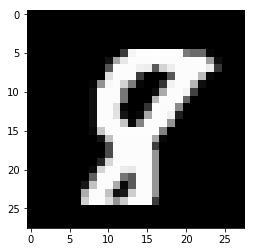

In [5]:
tf_filename = "/root/data/mnist_png/mnist_train_00000-of-00005.tfrecord"
image = []
format = []
label = []
height = []
width = []

#decoding from tf_filename
for serialized_example in tf.python_io.tf_record_iterator(tf_filename):
    #create tf record object and parsing
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image.append(example.features.feature['image/encoded'].bytes_list.value)
    format.append(example.features.feature['image/format'].bytes_list.value)
    label.append(example.features.feature['image/class/label'].int64_list.value)
    height.append(example.features.feature['image/height'].int64_list.value)
    width.append(example.features.feature['image/width'].int64_list.value)

print (len(image), len(format), len(label), len(height), len(width))
print (format[1][0], label[1][0], height[1][0], width[1][0])

with tf.Session('') as sess:
    #bytes_list image data to int image data
    image = tf.image.decode_png(image[1][0], channels=1)
    image_shape = tf.stack([height[1][0], width[1][0]])
    image = tf.reshape(image, image_shape)
    image = sess.run(image)


print (image.shape)
plt.imshow(image,  cmap='gray')
plt.show()

## string_input_producer
 
 filename을 produce 하기 위한 큐 <br/>
 FIFO 큐를 만들어 reader가 읽기 전까지 fiilename을 홀딩

In [13]:
filename_list = []
num_epochs = 1

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

print (filename_list)
filename_queue = tf.train.string_input_producer(filename_list, num_epochs=num_epochs)
reader = tf.TFRecordReader()
key, value = reader.read(filename_queue)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    step = 0 
    try:
        #while True:
        for i in range(5):
            #read tensorflow object
            print (sess.run([key]))
            step = step + 1
    
    except tf.errors.OutOfRangeError:
        print("Done training ")
        print (step)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")

['/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord']
  allow_growth: true
}
allow_soft_placement: true
)
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:0']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:285']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:688']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:977']
[b'/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord:1338']
thread Done:


## tf.train.shuffle.batch

 string input producer에서 파일을 읽은 후, batch 크기 단위로 저장 <br/>
 num_threads 변수 설정으로 prefetch reading threads 수 설정
 
 epoch limit된 string_input_producer와 사용시 epoch 전체를 수행하지 못하고 종료될 가능성 존재
  * epoch가 끝나고 filename queue 가 close되었지만 filename은 여전히 큐에 남아 있는 경우, <br/>
    reader가 파일 읽기를 시작할때 outOfrange 에러가 발생하며 남아있는 파일을 읽지 못하고 훈련이 종료됨 

['/root/data/mnist_png/mnist_validation_00000-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00001-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00002-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00003-of-00005.tfrecord', '/root/data/mnist_png/mnist_validation_00004-of-00005.tfrecord']
  allow_growth: true
}
allow_soft_placement: true
)
label (16,)
image (16, 28, 28, 1)


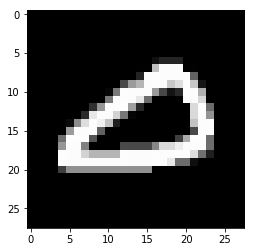

label (16,)
image (16, 28, 28, 1)


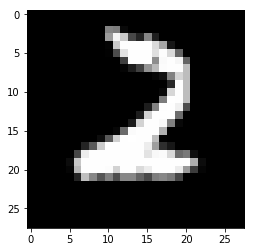

label (16,)
image (16, 28, 28, 1)


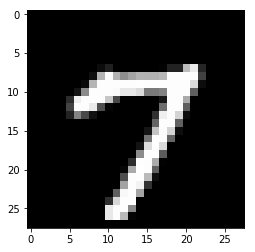

label (16,)
image (16, 28, 28, 1)


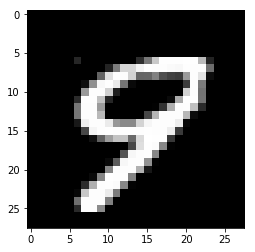

label (16,)
image (16, 28, 28, 1)


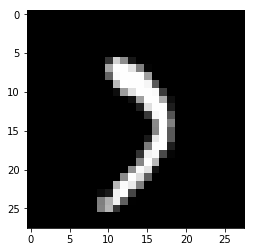

thread Done:


In [10]:
def read_and_decode(filename_queue):

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
            'image/height': tf.FixedLenFeature([], tf.int64),
            'image/width': tf.FixedLenFeature([], tf.int64),
        })

    label = tf.cast(features['image/class/label'], tf.int32)
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)

    image = tf.image.decode_jpeg(features['image/encoded'])

    image_shape = tf.stack([height, width, 1])
    image = tf.reshape(image, image_shape)

    return image, label

def preprocess_for_eval(image, height, width,
                        scope=None):
    
    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        if height and width:
            # Resize the image to the specified height and width.
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],
                                           align_corners=False)
            image = tf.squeeze(image, [0])
        return image

filename_list = []
num_epochs = 1

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

print (filename_list)
filename_queue = tf.train.string_input_producer(filename_list, num_epochs=num_epochs)    
    
image, label = read_and_decode(filename_queue)

image = preprocess_for_eval(image, 28, 28)

images, labels = tf.train.shuffle_batch(
            [image, label], batch_size=16, num_threads=1,
            capacity=800, allow_smaller_final_batch = True, min_after_dequeue=320 )

#min_after_dequeue: Minimum number elements in the queue after a dequeue, 
#                   used to ensure a level of mixing of elements.

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:

    sess.run(init_op)

    coord = tf.train.Coordinator() #coordinator for theads for termination
    threads = tf.train.start_queue_runners(sess=sess, coord=coord) #start threads that run the input pipeline
    
    try:
        for i in range(5):
            image, label = sess.run([images, labels])
            print ("label", np.shape(label))
            print ("image", np.shape(image))
            step = step + 1
            sample_image = np.reshape(image[0], (28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.show()
    except tf.errors.OutOfRangeError: #epoch limit has been reached
        print("Done training ", step, step*16)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")

## tf.contrib.dataset

input pipeline을 생성하기 위한 간편한 API
 * repeat를 이용하여 epoch 설정시, epoch 전체가 reading 된후 OutOfRangeError 발생
 * prefetch 지원 안됨


  allow_growth: true
}
allow_soft_placement: true
)
label (16,)
image (16, 28, 28, 1)


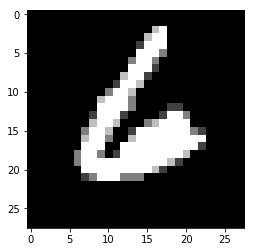

label (16,)
image (16, 28, 28, 1)


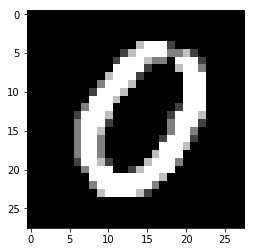

label (16,)
image (16, 28, 28, 1)


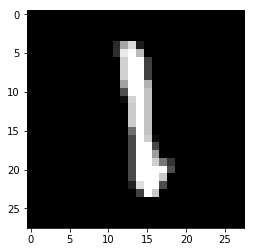

label (16,)
image (16, 28, 28, 1)


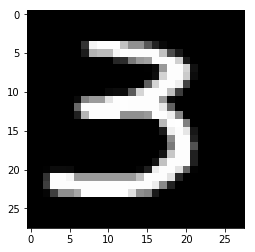

label (16,)
image (16, 28, 28, 1)


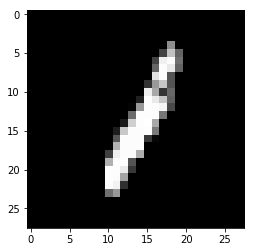

thread Done:


In [11]:
filename_list = []
num_epochs = 1
batch_size = 16

def read_and_decode(example_proto):

    #reader = tf.TFRecordReader()
    #_, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        example_proto,
        # Defaults are not specified since both keys are required.
        features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
            'image/height': tf.FixedLenFeature([], tf.int64),
            'image/width': tf.FixedLenFeature([], tf.int64),
        })

    label = tf.cast(features['image/class/label'], tf.int32)
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)

    image = tf.image.decode_jpeg(features['image/encoded'])

    image_shape = tf.stack([height, width, 1])
    image = tf.reshape(image, image_shape)

    return image, label

def preprocess_for_eval(image, label, height=28, width=28,
                        scope=None):
    
    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        if height and width:
            # Resize the image to the specified height and width.
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],
                                           align_corners=False)
            image = tf.squeeze(image, [0])
            
        return image, label

for i in range(_NUM_SHARDS):
    filename_list.append(os.path.join(_DATA_DIR,  
                                      'mnist_validation_%05d-of-%05d.tfrecord' % (i, _NUM_SHARDS)))

dataset = tf.contrib.data.TFRecordDataset(filename_list)
dataset = dataset.map(read_and_decode)
dataset = dataset.map(preprocess_for_eval)
#dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat(num_epochs)
dataset = dataset.batch(batch_size)

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:

    sess.run(init_op)
    
    try:
        for i in range(5):
            image, label = sess.run(next_element)
            print ("label", np.shape(label))
            print ("image", np.shape(image))
            step = step + 1
            sample_image = np.reshape(image[0], (28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.show()
    except tf.errors.OutOfRangeError:
        print("Done training ", step, step*16)
    finally:
        coord.request_stop()
        coord.join(threads)
        print ("thread Done:")